### 5. TEXT CLASSIFIERS - SUPERVISED METHODS

In this final section, I train supervised learning algorithms to classify death records with garbage underlying codes. The difficulty is that I start with records that have valid underlying cause codes as the pre-labeled training data set.  The labels are the broad leading cause of death ICD-10 code groupings to which I'd like to assign the garbage coded records.  Ideally, I would have started with a training data set consisting of garbage coded records that were labeled with specific causes of death by experts who reviewed the death record and other medical information.

I used two algorithms for this section.  The first was multinomial Naive Bayes and the second was Support Vector Machine.

In [29]:
from joblib import dump, load
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import sre_yield
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV

from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn import svm

from sklearn.metrics import accuracy_score, confusion_matrix


**Overview of process**

I implemented the following steps to run the models:

- select records without valid ICD-10 underlying cause codes to train and test models,
- create labels (10 leading causes of death) by grouping ICD-10 codes,
- label records,
- preprocess text and ICD-10 codes,
- train models
    - Linear SVM
    - Naive Bayes
- check accuracy of both models
- apply best performing model to garbage coded records
    - remove labels if target category is implausible
- compare classification with LDA

In [30]:
death_df = pd.read_csv(r'Y:/DQSS/Death/MBG/py/capstone2/data/d1619_clean.csv',
                       low_memory=False,
                       encoding = 'unicode_escape')

In [31]:
death_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226997 entries, 0 to 226996
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   sfn           226997 non-null  int64  
 1   sex           226997 non-null  object 
 2   dody          226997 non-null  int64  
 3   dcounty       226996 non-null  object 
 4   hispanic      226997 non-null  object 
 5   race          226997 non-null  object 
 6   agegrp        225535 non-null  object 
 7   manner        226955 non-null  object 
 8   tobac         226912 non-null  object 
 9   pg            166760 non-null  float64
 10  gc_cat        226997 non-null  int64  
 11  gc_cat_label  226997 non-null  object 
 12  UCOD          226841 non-null  object 
 13  MC2           188306 non-null  object 
 14  AllMC         226997 non-null  object 
 15  MC2_20        226997 non-null  object 
 16  codlit        226996 non-null  object 
 17  cert_label    226997 non-null  object 
dtypes: f

In [32]:
death_df.gc_cat_label.value_counts()

0-No GC                         211924
6-Ill-defined cardiovascular      3868
5-Ill-defined                     2973
2-Heart failure                   2767
3-Ill-defined cancer              2376
1-Septicemia                      2149
4-Volume depletion                 534
8-Undetermined intent              368
9-Ill-defined infectious            38
Name: gc_cat_label, dtype: int64

In [33]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', None)

In [34]:
death_df.head()

,sfn,sex,dody,dcounty,hispanic,race,agegrp,manner,tobac,pg,gc_cat,gc_cat_label,UCOD,MC2,AllMC,MC2_20,codlit,cert_label
0,2017025187,M,2017,KING,No,White,80+ yrs,N,N,8.0,0,0-No GC,J841,I10,J841 I10 I219 I269 I48 I509 J690 J960 R090 ...,I10 I219 I269 I48 I509 J690 J960 R090,ACUTE RESPIRATORY FAILURE WITH HYPOXIA ASPIRAT...,1-Physician
1,2017025188,M,2017,KING,No,White,50-59 yrs,N,N,8.0,0,0-No GC,I64,NaN,I64,,ACUTE ISCHEMIC CEREBRAL VASCULAR ACCIDENT,7-ARNP
2,2017025189,F,2017,KING,No,Asian,70-79 yrs,N,N,8.0,0,0-No GC,C833,D619,C833 D619 E46 E883 R58 Y433,D619 E46 E883 R58 Y433,RETROPERITONEAL BLEEDING EXTENSIVE LARGE B CEL...,1-Physician
3,2017025190,F,2017,KING,No,White,80+ yrs,N,N,8.0,4,4-Volume depletion,E86,N179,E86 N179 R13,N179 R13,ACUTE RENAL FAILURE DEHYDRATION DYSPHAGIA,1-Physician
4,2017025191,M,2017,SPOKANE,No,White,70-79 yrs,N,Y,8.0,4,4-Volume depletion,E870,F54,E870 F54 G729 I509 J969 R093 R418 R53 T179 W80...,F54 G729 I509 J969 R093 R418 R53 T179 W80 ...,PULSELESS ELECTRICAL ACTIVITY ARREST HYPOXEMIC...,1-Physician


In [35]:
df = death_df.copy()
len(df)

226997

**ATTACHING LABELS** The data frame consists of records with non-garbage underlying cause codes.  ICD-10 codes in the underlying cause variable are typically grouped together to more meaningful categories that are used to understand mortality patterns.  For example, while lung cancer deaths are assigned a code between C34.0 and C34.9 (based on the specific location of the cancer), typically, leading cause of death analyses will group deaths due to any cancer into the "malignant neoplasm" category which contains all codes from C00.0 through C97.9.

In the next step, all deaths in the data frame will be labeled with one of ten causes of death that are leading causes in Washington State (and most of the United States). Together, these ten causes account for ___ % of all deaths in the state.  It is very likely that the poorly coded records will belong to one of these groups.

In [36]:

# all cancer (C00–C97)
cancer = []

for code in sre_yield.AllStrings(r'^C[0-8][0-9][0-9]{0,1}'):
    cancer.append(code)
    
for code in sre_yield.AllStrings(r'^C9[0-7][0-9]{0,1}'):
    cancer.append(code)

# all heart disease (I00–I09,I11,I13,I20–I51)
 
heart_disease = []

for code in sre_yield.AllStrings(r'^I[00][0-9][0-9]{0,1}'):
    heart_disease.append(code)

for code in sre_yield.AllStrings(r'^I13[0-9]{0,1}'):
    heart_disease.append(code)

for code in sre_yield.AllStrings(r'^I[2-4][0-9][0-9]{0,1}'):
    heart_disease.append(code)

for code in sre_yield.AllStrings(r'^I51[0-9]{0.1}'):
    heart_disease.append(code)

# Cerebrovasular disease  (I60–I69)

cerebrovascular_disease = []

for code in sre_yield.AllStrings(r'^I6[0-9][0-9]{0,1}'):
    cerebrovascular_disease.append(code)

# Diabetes (E10–E14)

diabetes = []

for code in sre_yield.AllStrings(r'^E1[0-4][0-9]{0,1}'):
    diabetes.append(code)
    
# Alzheimer's disease(G30)
                                 
alzheimers = []

for code in sre_yield.AllStrings(r'^G30[0,1,8,9]{0,1}'):
    alzheimers.append(code)
    
# Influenza and Pneumonia (J09–J18)
    
flu_pneumonia = []

for code in sre_yield.AllStrings(r'^J09[0-1]{0,1}'):
    flu_pneumonia.append(code)
    
for code in sre_yield.AllStrings(r'^J1[0-8][0-9]{0,1}'):
    flu_pneumonia.append(code)
    
    
# chronic lower respiratory disease (J40–J47)

clrd = []

for code in sre_yield.AllStrings(r'^J4[0-7][0-9]{0,1}'):
    clrd.append(code)
    
# Chronic liver disease and cirrhosis (K70,K73–K74)    

liver_dis = []

for code in sre_yield.AllStrings(r'^K70[0-9]{0,1}'):
    liver_dis.append(code)

for code in sre_yield.AllStrings(r'^K7[3-4][0-9]{0,1}'):
    liver_dis.append(code)
        
# Suicide (*U03,X60–X84,Y87.0)
suicide = []

for code in sre_yield.AllStrings(r'^U03(0-9)?'):
    suicide.append(code)

for code in sre_yield.AllStrings(r'^X[6-7][0-9](0-9)?'):
    suicide.append(code)
    
for code in sre_yield.AllStrings(r'^X8[0-4](0-9)?'):
    suicide.append(code)
    
for code in sre_yield.AllStrings(r'^Y870'):
    suicide.append(code)     
                                 

#Unintentional injury (V01–X59,Y85–Y86)

accident = []

for code in sre_yield.AllStrings(r'^V[0-9][0-9](0-9)?'):
    accident.append(code)
    
for code in sre_yield.AllStrings(r'^W[0-9][0-0](0-9)?'):
    accident.append(code)

for code in sre_yield.AllStrings(r'^X[0-5][0-9](0-9)?'):
    accident.append(code)    

        

In [37]:
leading_cause_dict = {1: cancer,
                      2: heart_disease,
                      3: cerebrovascular_disease,
                      4: diabetes,
                      5: alzheimers,
                      6: flu_pneumonia,
                      7: clrd,
                      8: liver_dis,
                      9: suicide,
                      10: accident
                     }

In [38]:
lcod_dict_rev = {v: k for k in leading_cause_dict for v in leading_cause_dict[k]}

#the above is functional equivalent of:
#lcod_dict_rev = {}
#for key in leading_cause_dict:
#    for value in leading_cause_dict[key]:
#        gcdict_rev[value] = key

In [39]:
lcod_label_dict = {1: 'Cancer',
                   2: 'Heart disease',
                   3: 'Cerebrovascular disease',
                   4: 'Diabetes',
                   5: 'Alzheimers',
                   6: 'Influenza pneumonia',
                   7: 'Chronic lower resp. dis.',
                   8: 'Liver disease',
                   9: 'Suicide',
                   10: 'Unintentional injury',
                   11: 'Other'}

In [40]:
df['leading_cause'] = df['UCOD'].map(lcod_dict_rev).fillna(11).astype(int)
df['lcod_labels'] = df['leading_cause'].map(lcod_label_dict)  

In [41]:
df.lcod_labels.value_counts()

Other                       73298
Cancer                      51256
Heart disease               38612
Alzheimers                  14522
Chronic lower resp. dis.    12287
Cerebrovascular disease     11893
Diabetes                     7141
Unintentional injury         5372
Suicide                      4969
Liver disease                3982
Influenza pneumonia          3665
Name: lcod_labels, dtype: int64

In [42]:
round(df.lcod_labels.value_counts(normalize=True)*100,1)

Other                       32.3
Cancer                      22.6
Heart disease               17.0
Alzheimers                   6.4
Chronic lower resp. dis.     5.4
Cerebrovascular disease      5.2
Diabetes                     3.1
Unintentional injury         2.4
Suicide                      2.2
Liver disease                1.8
Influenza pneumonia          1.6
Name: lcod_labels, dtype: float64

In [43]:
df.gc_cat_label.value_counts()

0-No GC                         211924
6-Ill-defined cardiovascular      3868
5-Ill-defined                     2973
2-Heart failure                   2767
3-Ill-defined cancer              2376
1-Septicemia                      2149
4-Volume depletion                 534
8-Undetermined intent              368
9-Ill-defined infectious            38
Name: gc_cat_label, dtype: int64

**Remove rows with missing values in MC2 - MC20** as these will not contribute much when training supervised models.

In [44]:
df.head()

,sfn,sex,dody,dcounty,hispanic,race,agegrp,manner,tobac,pg,gc_cat,gc_cat_label,UCOD,MC2,AllMC,MC2_20,codlit,cert_label,leading_cause,lcod_labels
0,2017025187,M,2017,KING,No,White,80+ yrs,N,N,8.0,0,0-No GC,J841,I10,J841 I10 I219 I269 I48 I509 J690 J960 R090 ...,I10 I219 I269 I48 I509 J690 J960 R090,ACUTE RESPIRATORY FAILURE WITH HYPOXIA ASPIRAT...,1-Physician,11,Other
1,2017025188,M,2017,KING,No,White,50-59 yrs,N,N,8.0,0,0-No GC,I64,NaN,I64,,ACUTE ISCHEMIC CEREBRAL VASCULAR ACCIDENT,7-ARNP,3,Cerebrovascular disease
2,2017025189,F,2017,KING,No,Asian,70-79 yrs,N,N,8.0,0,0-No GC,C833,D619,C833 D619 E46 E883 R58 Y433,D619 E46 E883 R58 Y433,RETROPERITONEAL BLEEDING EXTENSIVE LARGE B CEL...,1-Physician,1,Cancer
3,2017025190,F,2017,KING,No,White,80+ yrs,N,N,8.0,4,4-Volume depletion,E86,N179,E86 N179 R13,N179 R13,ACUTE RENAL FAILURE DEHYDRATION DYSPHAGIA,1-Physician,11,Other
4,2017025191,M,2017,SPOKANE,No,White,70-79 yrs,N,Y,8.0,4,4-Volume depletion,E870,F54,E870 F54 G729 I509 J969 R093 R418 R53 T179 W80...,F54 G729 I509 J969 R093 R418 R53 T179 W80 ...,PULSELESS ELECTRICAL ACTIVITY ARREST HYPOXEMIC...,1-Physician,11,Other


In [45]:

df.dropna(subset = ['MC2'], inplace=True)
len(df)

188306

In [46]:
df.head()

,sfn,sex,dody,dcounty,hispanic,race,agegrp,manner,tobac,pg,gc_cat,gc_cat_label,UCOD,MC2,AllMC,MC2_20,codlit,cert_label,leading_cause,lcod_labels
0,2017025187,M,2017,KING,No,White,80+ yrs,N,N,8.0,0,0-No GC,J841,I10,J841 I10 I219 I269 I48 I509 J690 J960 R090 ...,I10 I219 I269 I48 I509 J690 J960 R090,ACUTE RESPIRATORY FAILURE WITH HYPOXIA ASPIRAT...,1-Physician,11,Other
2,2017025189,F,2017,KING,No,Asian,70-79 yrs,N,N,8.0,0,0-No GC,C833,D619,C833 D619 E46 E883 R58 Y433,D619 E46 E883 R58 Y433,RETROPERITONEAL BLEEDING EXTENSIVE LARGE B CEL...,1-Physician,1,Cancer
3,2017025190,F,2017,KING,No,White,80+ yrs,N,N,8.0,4,4-Volume depletion,E86,N179,E86 N179 R13,N179 R13,ACUTE RENAL FAILURE DEHYDRATION DYSPHAGIA,1-Physician,11,Other
4,2017025191,M,2017,SPOKANE,No,White,70-79 yrs,N,Y,8.0,4,4-Volume depletion,E870,F54,E870 F54 G729 I509 J969 R093 R418 R53 T179 W80...,F54 G729 I509 J969 R093 R418 R53 T179 W80 ...,PULSELESS ELECTRICAL ACTIVITY ARREST HYPOXEMIC...,1-Physician,11,Other
5,2017025192,M,2017,KING,No,White,70-79 yrs,N,P,8.0,0,0-No GC,C349,C679,C349 C679 C793 E039 E785 F179 I10 I48 I64 ...,C679 C793 E039 E785 F179 I10 I48 I64,LUNG CANCER METASTATIC TO BRAIN ATRIAL FIBR...,1-Physician,1,Cancer


The dataframe originally consisted of 226,996 records but after removing rows with missing values in these multiple cause fields the dataset is reduced to 177,362 rows. This means that for the dropped rows the medical certifier reported only one condition leading to the cause of death.

**PREPROCESS CAUSE OF DEATH ICD 10 CODE FIELDS**

In [47]:
## call stored object 'gc_all' created in 2_PrepData_ICD10.ipynb.
%store -r gc_all 
%store -r g3

In [48]:
# Keep records with valid underlying cause code and selected variables

selectedcols = ['lcod_labels', 'MC2', 'AllMC','MC2_20', 'agegrp', 'sex', 'tobac','manner']
df = df.loc[df['gc_cat']==0, selectedcols]

In [49]:
df['lcod_id'] = df['lcod_labels'].factorize()[0]

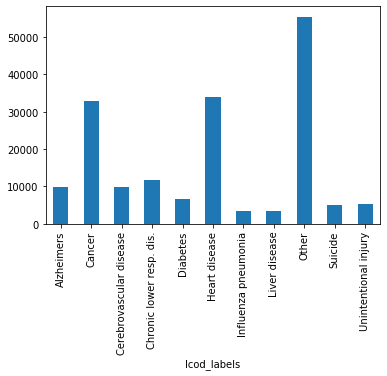

In [50]:
df.groupby('lcod_labels').lcod_id.count().plot.bar(ylim=0)
plt.show()

**Cancer and heart disease deaths dominate** in addition to the 'other' category in the dataset of records with valid (non-garbage) underlying cause codes.  Chronic lower respiratory disease, Alzheimer's disease, and cerebrovascular disease are also among the top five most common causes of death in Washington State in this period. The catchall category of 'Other' causes of death encompasses a variety of diseases and conditions that together account for 31% of the deaths. 

In [51]:
# restrict records to those in one of the 10 leading causes of death

df = df.loc[df['lcod_labels']!='Other', :]
len(df)

121947

#### Multnomial Naive Bayes Classifier

The text data used to train this classifier is in the column called "mc2_20" which consists of a concatenation of all ICD-10 codes in positions MC2 through MC20.  'mc2_20' does not include MC1 which is always populated with the underlying cause ICD-10 code.  The reason for excluding the underlying cause code is to see how well the remaining multiple cause codes can predict the leading cause of death category to which the observation belongs. Providing MC1 to train the model would be similar to providing the labels as one of the training features.

In [52]:
# train MNB model and predict labels in test data

Xtrain, Xtest, ytrain, ytest = train_test_split(df['MC2_20'],df['lcod_id'], 
                                                test_size=0.3, 
                                                random_state = 77)


tfidf_vect = TfidfVectorizer(sublinear_tf=True, min_df=100, lowercase=False, ngram_range=(1, 2))
tfidf_vect.fit(df['MC2_20'])

X_train_tfidf = tfidf_vect.transform(Xtrain)
X_test_tfidf = tfidf_vect.transform(Xtest)

mnb = MultinomialNB()
mnb_clf = mnb.fit(X_train_tfidf, ytrain)

MNB_prediction = mnb_clf.predict(X_test_tfidf)

In [53]:
# check accuracy of MNB model

print('Multinomial Naive Bayes classifier accuracy:', 
      round(accuracy_score(ytest, MNB_prediction)*100,1),'%')

Multinomial Naive Bayes classifier accuracy: 60.2 %


In [54]:
target_names = list(lcod_label_dict.values())
target_names = target_names[0:10] #remove 'other' label

In [55]:
from sklearn.metrics import classification_report
cr = classification_report(ytest, MNB_prediction, target_names = target_names)
print(cr)

                          precision    recall  f1-score   support

                  Cancer       0.62      0.71      0.66      9890
           Heart disease       0.49      0.28      0.36      2917
 Cerebrovascular disease       0.55      0.83      0.66     10111
                Diabetes       0.83      0.82      0.83      1607
              Alzheimers       0.51      0.12      0.19      1043
     Influenza pneumonia       0.60      0.14      0.23      2038
Chronic lower resp. dis.       0.60      0.33      0.42      3562
           Liver disease       0.54      0.45      0.49      2925
                 Suicide       0.95      0.85      0.90      1485
    Unintentional injury       0.77      0.33      0.47      1007

                accuracy                           0.60     36585
               macro avg       0.65      0.49      0.52     36585
            weighted avg       0.61      0.60      0.58     36585



Multnimoial Naive Bayes classifier only had an accuracy of 60% in classifying records based on muliple cause codes into one of 10 cause of death groups.

The precision (ratio of true positives to true positives + false positives) for the ten categories ranged from 48% (Diabetes) to 96% (liver disease). Recall, or sensitivity, ranged from 8% for influenza and pneumonia to 85% for heart disease. While accuracy score (60%) is affected by specificity, F1 score balances the impact of precision and recall when there's uneven distribution among the classes (which there is).

#### Linear Support Vector Machine

Linear support vector classifier
- garbage codes left intact
- all cause of death categories

In [56]:
## Algorithm: Support Vector Machine

lin_svc = svm.LinearSVC()
lin_svc.fit(X_train_tfidf, ytrain)

SVC_prediction = lin_svc.predict(X_test_tfidf)

In [57]:
print("SVM accuracy score:", round(accuracy_score(SVC_prediction, ytest)*100,1), "%")

SVM accuracy score: 62.7 %


The accuracy of support vector machine algorithm is not much better than the multinomial Naive Bayes model trained above to classify deaths into 10 cause of death groups.

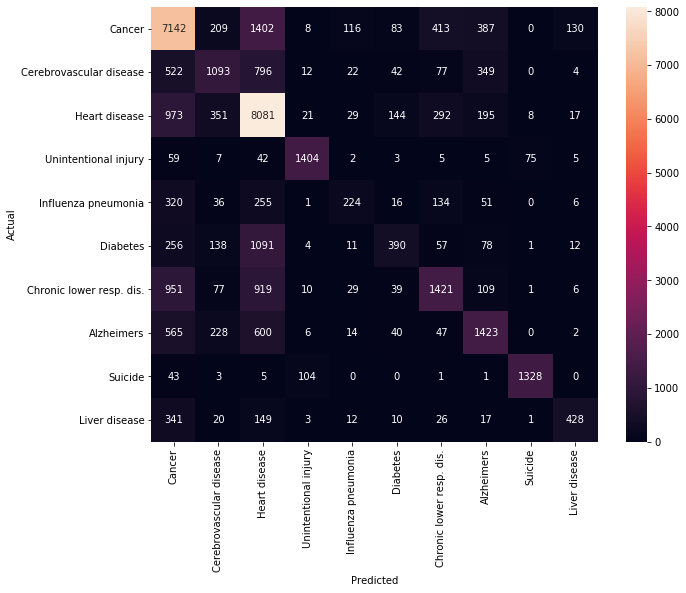

In [58]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(ytest, SVC_prediction)
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(conf_mat, annot=True, fmt='g',
           xticklabels = lcod_df.lcod_labels.values,
           yticklabels = lcod_df.lcod_labels.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


The confusion matrix plot shows the areas in which missclassification is most likely to occur.  For example true Alzheimer's disease deaths and heart disease deaths are often misclassified as cancer deaths.

In [59]:
cr = classification_report(ytest, SVC_prediction, target_names = target_names)
print(cr)

                          precision    recall  f1-score   support

                  Cancer       0.64      0.72      0.68      9890
           Heart disease       0.51      0.37      0.43      2917
 Cerebrovascular disease       0.61      0.80      0.69     10111
                Diabetes       0.89      0.87      0.88      1607
              Alzheimers       0.49      0.21      0.30      1043
     Influenza pneumonia       0.51      0.19      0.28      2038
Chronic lower resp. dis.       0.57      0.40      0.47      3562
           Liver disease       0.54      0.49      0.51      2925
                 Suicide       0.94      0.89      0.92      1485
    Unintentional injury       0.70      0.43      0.53      1007

                accuracy                           0.63     36585
               macro avg       0.64      0.54      0.57     36585
            weighted avg       0.62      0.63      0.61     36585



The accuracy, precision, recall, and F1 scores for support vector machine is not very different from those of the Naive Bayes model.

**TRAINING A ONE VS. ALL CLASSIFIER FOR EACH OF THE 5 LEADING CAUSES OF DEATH**

In the previous attempts, the algorithms were trained as multi-class text classifiers.  In the following attempts I will build a 'one vs. all' approach with both Multinomial Naive Bayes and SVM models using two classes only.  The classes will be the selected leading cause vs. all other causes of deaths.  Again, no garbage codes will be removed in the first attempt.

In [60]:
def classify_oneVall(df):
    
    Lcods = ['Cancer','Heart disease','Alzheimers','Cerebrovascular disease', 'Diabetes', 'Chronic lower resp. dis.']
    Models = [MultinomialNB, LinearSVC]
    
    for lcod in Lcods:
  
        df[lcod] = 0
        df.loc[df['lcod_labels']==lcod, lcod]=1
    
        TrainX, TestX, train_y, test_y = train_test_split(df['MC2_20'], df[lcod],
                                                                           test_size=0.3,
                                                                           random_state=7)
        tfidf_vect = TfidfVectorizer(sublinear_tf=True,
                                         min_df=10, 
                                         lowercase=False, 
                                         ngram_range=(1, 2))
            
        tfidf_vect.fit(df['MC2_20'])
        TrainX_tfidf = tfidf_vect.transform(TrainX)
        TestX_tfidf = tfidf_vect.transform(TestX)
        
        for model in Models:          
            clf = model()
            clf.fit(TrainX_tfidf, train_y)

            clf_prediction = clf.predict(TestX_tfidf)
            print("Accuracy score:", model, lcod, round(accuracy_score(clf_prediction, test_y)*100,1), "%")
            cr=classification_report(test_y, clf_prediction)
            print(cr)


In [61]:
classify_oneVall(df)

Accuracy score: <class 'sklearn.naive_bayes.MultinomialNB'> Cancer 83.6 %
              precision    recall  f1-score   support

           0       0.86      0.93      0.89     26729
           1       0.76      0.58      0.66      9856

    accuracy                           0.84     36585
   macro avg       0.81      0.76      0.77     36585
weighted avg       0.83      0.84      0.83     36585

Accuracy score: <class 'sklearn.svm._classes.LinearSVC'> Cancer 84.1 %
              precision    recall  f1-score   support

           0       0.86      0.93      0.90     26729
           1       0.76      0.59      0.67      9856

    accuracy                           0.84     36585
   macro avg       0.81      0.76      0.78     36585
weighted avg       0.84      0.84      0.83     36585

Accuracy score: <class 'sklearn.naive_bayes.MultinomialNB'> Heart disease 82.2 %
              precision    recall  f1-score   support

           0       0.86      0.90      0.88     26356
           

Accuracy of the Naive Bayes model is vastly improved with a two group classifier.

**Retraining the two models using text data stripped of garbage codes**

I attempted to retrain the models using only valid ICD-10 codes but these models performed slightly worse than the ones above.

NEXT STEPS:

- grid search for best parameter values for SVM model along with cross validation
- use cause of death text instead of ICD-10 codes

**SVM grid search**

In [63]:
df['cancer'] = 0
df.loc[df['lcod_labels']=="Cancer", 'cancer']=1
    
TrainX, TestX, train_y, test_y = train_test_split(df['MC2_20'], df['cancer'],
                                                              test_size=0.3,
                                                             random_state=7)

tfidf_vect = TfidfVectorizer(sublinear_tf=True,
                                         min_df=10, 
                                         lowercase=False, 
                                         ngram_range=(1, 2))
            
tfidf_vect.fit(df['MC2_20'])
TrainX_tfidf = tfidf_vect.transform(TrainX)
TestX_tfidf = tfidf_vect.transform(TestX)
        

In [64]:
from sklearn.model_selection import GridSearchCV

def svc_param_selection(X, y):
    Cs = [0.001, 0.01, 0.1, 1 ,10]
    param_grid = {'C': Cs, }
    grid_search = GridSearchCV(LinearSVC(), param_grid, n_jobs=4, verbose=3)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [65]:
svc_param_selection(TrainX_tfidf, train_y)


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:  2.0min finished


{'C': 0.1}

The'C' parameter (regularization parameter) optimizes the SCM classifier by specifying the margin between the hyperplane and the support vectors.  A large value of C will choose smaller margins where as a small value of C will specify a larger margin in order to best classify the points correctly.

In this case grid searching yielded a C value of 0.1 (out of possible values of 0.001, 0.01, 0.1, 1, and 10).

The drawback of training these classifiers on data with valid underlying cause codes is that in general these records are more likely to contain meaningful codes (both underlying cause code and upto 19 additional multiple cause codes).  Records with garbage codes for underlying cause codes may not contain as much useful information in the multiple cause fields to allow accurate classification with a model trained on valid codes.

**APPLICATION OF LINEAR SVC TO GARBAGE CODED RECORDS**

In the series of two-class classifications using Multinomial Naive Bayes and Linear Support Vector Machine the latter seems to perform a little better in a few instances (cancer and heart disease classifiers). For the remainder of this analysis I'll use Linear SVM in classifying the records with garbage underlying cause codes.

I created a function to generate linear SVC models for each of the six leading causes of death that I'm working with.  For each cause of death I create both the linear SVC model and the tfidf vectorizer which converts the disease specific corpus into vectors and learns patterns of tf-idf values for the two classes in each model (death due to the disease of interest vs death due to something else).

In [139]:

lin_SVC_mods=[]
t_Vecs = [] 

def LinSVC_2class(df):
    
    Lcods = ['Cancer','Heart disease','Alzheimers','Cerebrovascular disease', 'Diabetes', 'Chronic lower resp. dis.']
    
    for lcod in Lcods:   
            
        df[lcod] = 0
        df.loc[df['lcod_labels']==lcod, lcod]=1
        
            
        TrainX, TestX, train_y, test_y = train_test_split(df['MC2_20'], df[lcod],
                                                              test_size=0.1,
                                                             random_state=7)

        tfidf_vect = TfidfVectorizer(sublinear_tf=True,
                                         min_df=10, 
                                         lowercase=False, 
                                         ngram_range=(1, 2))
        
        tfidf_vect.fit(df['MC2_20'])
        TrainX_tfidf = tfidf_vect.transform(TrainX)
        
        
        svm = LinearSVC(C=0.1)
        clf = CalibratedClassifierCV(svm) #includes 5-fold CV
        clf.fit(TrainX_tfidf, train_y)
        
        mod_name = lcod + '_lsvc.joblib' 
        lin_SVC_mods.append(mod_name)
        
        tf_name = lcod + '_tvect.joblib'
        t_Vecs.append(tf_name)
       
        dump(clf, mod_name)
        dump(tfidf_vect, tf_name)
        
        print('classifier built: ' + mod_name)
     

In [140]:
LinSVC_2class(df)

classifier built: Cancer_lsvc.joblib
classifier built: Heart disease_lsvc.joblib
classifier built: Alzheimers_lsvc.joblib
classifier built: Cerebrovascular disease_lsvc.joblib
classifier built: Diabetes_lsvc.joblib
classifier built: Chronic lower resp. dis._lsvc.joblib


**Apply the linear SVM models sequentially to the garbage code data set**

Here I subset the original dataframe to keep only those records that have garbage codes for underlying causes.  I applied each of the six disease-specific linear SVC models to the garbage code records to get a probability that the death was due to the disease of interest e.g. the probability for each record that it was due to cancer or due to heart disease etc.

In [250]:
gc_df = death_df.loc[death_df['gc_cat']!=0, :]
len(gc_df)

15073

In [252]:
gc_df.gc_cat_label.value_counts(dropna=False)

6-Ill-defined cardiovascular    3868
5-Ill-defined                   2973
2-Heart failure                 2767
3-Ill-defined cancer            2376
1-Septicemia                    2149
4-Volume depletion               534
8-Undetermined intent            368
9-Ill-defined infectious          38
Name: gc_cat_label, dtype: int64

In [237]:
gc_df.dropna(subset = ['MC2'], inplace=True)
len(gc_df)

<ipython-input-237-f338e9bead4b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gc_df.dropna(subset = ['MC2'], inplace=True)


10944

In [238]:
gc_df.gc_cat_label.value_counts(dropna=False)

6-Ill-defined cardiovascular    3347
2-Heart failure                 2174
1-Septicemia                    2010
3-Ill-defined cancer            1821
5-Ill-defined                    667
4-Volume depletion               524
8-Undetermined intent            365
9-Ill-defined infectious          36
Name: gc_cat_label, dtype: int64

In [239]:
## drop categories 8 and 9 because they cannot be recoded into cancer, heart disease,
## Alzheimers, cerebrovascular disease, diabetes, or chronic lower respiratory disease.

gc_df = gc_df.loc[gc_df['gc_cat'].isin([1, 2, 3, 4, 5, 6]), :]
gc_df.gc_cat_label.value_counts(dropna=False), len(gc_df)

(6-Ill-defined cardiovascular    3347
 2-Heart failure                 2174
 1-Septicemia                    2010
 3-Ill-defined cancer            1821
 5-Ill-defined                    667
 4-Volume depletion               524
 Name: gc_cat_label, dtype: int64,
 10543)

**Create function to iterate through 

In [341]:
len(gc_df2)

15073

In [260]:
## get probabilities that the record is a death due to one of the leading causes of death
prob_lists = []
cols = []

def get_class_probability(text, model_list, tfidf_vector_list):
    
    for m, t in zip(model_list, tfidf_vector_list):
        
        tfidf_vect = load(t)
        svm_mod = load(m)
       
        tfidf_text = tfidf_vect.transform(text) 
        pred_prob = list(svm_mod.predict_proba(tfidf_text)[:,1])
    
        new_name = m[:-12]
        
        prob_lists.append(pred_prob)
        cols.append(new_name)
        
        print("new column added to data set:", new_name)
    

In [261]:
prob_lists = []
cols = []
get_class_probability(gc_df['MC2_20'], lin_SVC_mods, t_Vecs)

new column added to data set: Cancer
new column added to data set: Heart disease
new column added to data set: Alzheimers
new column added to data set: Cerebrovascular disease
new column added to data set: Diabetes
new column added to data set: Chronic lower resp. dis.


In [265]:
len(prob_lists)

6

In [269]:
#create dataframe from probabilities and column names

prob_df = pd.DataFrame.from_records(prob_lists, cols)

prob_df = pd.DataFrame.transpose(prob_df.round(3)*100)

In [267]:
gc_df.reset_index(inplace=True, drop=True)
gc_df.head()

,sfn,sex,dody,dcounty,hispanic,race,agegrp,manner,tobac,pg,gc_cat,gc_cat_label,UCOD,MC2,AllMC,MC2_20,codlit,cert_label
0,2017025190,F,2017,KING,No,White,80+ yrs,N,N,8.0,4,4-Volume depletion,E86,N179,E86 N179 R13,N179 R13,ACUTE RENAL FAILURE DEHYDRATION DYSPHAGIA,1-Physician
1,2017025191,M,2017,SPOKANE,No,White,70-79 yrs,N,Y,8.0,4,4-Volume depletion,E870,F54,E870 F54 G729 I509 J969 R093 R418 R53 T179 W80...,F54 G729 I509 J969 R093 R418 R53 T179 W80 ...,PULSELESS ELECTRICAL ACTIVITY ARREST HYPOXEMIC...,1-Physician
2,2017019369,F,2017,PIERCE,No,White,80+ yrs,N,N,8.0,2,2-Heart failure,I500,NaN,I500,,PROBABLE CONGESTIVE HEART FAILURE HOSPICE,1-Physician
3,2017014601,F,2017,KING,No,White,70-79 yrs,N,N,8.0,1,1-Septicemia,A419,I469,A419 I469 R092,I469 R092,"RESPIRATORY AND CARDIAC ARREST SEVERE SEPSIS, ...",1-Physician
4,2017025200,F,2017,SNOHOMISH,No,White,80+ yrs,N,N,8.0,2,2-Heart failure,I500,D469,I500 D469 I802 J189 T828 Y831,D469 I802 J189 T828 Y831,"CONGESTIVE HEART FAILURE, CAUSE NOT FORMALLY W...",1-Physician


In [270]:
prob_df.head()

,Cancer,Heart disease,Alzheimers,Cerebrovascular disease,Diabetes,Chronic lower resp. dis.
0,9.3,6.0,22.9,30.6,4.9,2.6
1,5.0,21.3,14.3,9.0,3.8,8.1
2,29.8,14.0,7.9,5.0,3.6,4.1
3,22.6,12.7,6.2,6.6,3.7,14.4
4,46.2,74.6,5.8,1.7,0.6,1.1


In [273]:
gc_df2 = pd.concat([gc_df, prob_df], axis=1)
gc_df2.head(4)

,sfn,sex,dody,dcounty,hispanic,race,agegrp,manner,tobac,pg,gc_cat,gc_cat_label,UCOD,MC2,AllMC,MC2_20,codlit,cert_label,Cancer,Heart disease,Alzheimers,Cerebrovascular disease,Diabetes,Chronic lower resp. dis.
0,2017025190,F,2017,KING,No,White,80+ yrs,N,N,8.0,4,4-Volume depletion,E86,N179,E86 N179 R13,N179 R13,ACUTE RENAL FAILURE DEHYDRATION DYSPHAGIA,1-Physician,9.3,6.0,22.9,30.6,4.9,2.6
1,2017025191,M,2017,SPOKANE,No,White,70-79 yrs,N,Y,8.0,4,4-Volume depletion,E870,F54,E870 F54 G729 I509 J969 R093 R418 R53 T179 W80...,F54 G729 I509 J969 R093 R418 R53 T179 W80 ...,PULSELESS ELECTRICAL ACTIVITY ARREST HYPOXEMIC...,1-Physician,5.0,21.3,14.3,9.0,3.8,8.1
2,2017019369,F,2017,PIERCE,No,White,80+ yrs,N,N,8.0,2,2-Heart failure,I500,NaN,I500,,PROBABLE CONGESTIVE HEART FAILURE HOSPICE,1-Physician,29.8,14.0,7.9,5.0,3.6,4.1
3,2017014601,F,2017,KING,No,White,70-79 yrs,N,N,8.0,1,1-Septicemia,A419,I469,A419 I469 R092,I469 R092,"RESPIRATORY AND CARDIAC ARREST SEVERE SEPSIS, ...",1-Physician,22.6,12.7,6.2,6.6,3.7,14.4


For records with a higher probability (greater than 50%) of being one of the leading causes of death I will flag the record as a candidate for redistribution to that cause of death.  If more than one cause of death has a higher probability, I will select the cause of death which is most likely to be the correct one based on this model's prediction.

In [ ]:
causes = ['Cancer', 'Heart disease','Alzheimers','Cerebrovascular disease','Diabetes','Chronic lower resp. dis.']

gc_df2['flag'] = (gc_df2[causes]>50).any(axis=1)


In [336]:
gc_df2['svm_class'] = gc_df2.loc[gc_df2['flag']==True, ['Cancer', 'Heart disease','Alzheimers','Cerebrovascular disease','Diabetes','Chronic lower resp. dis.']].idxmax(axis=1)

In [338]:
gc_df2.head(10)

,sfn,sex,dody,dcounty,hispanic,race,agegrp,manner,tobac,pg,gc_cat,gc_cat_label,UCOD,MC2,AllMC,MC2_20,codlit,cert_label,Cancer,Heart disease,Alzheimers,Cerebrovascular disease,Diabetes,Chronic lower resp. dis.,svm_class,svm_class2,"(True, svm_class)",flag,svm_class3
0,2017025190,F,2017,KING,No,White,80+ yrs,N,N,8.0,4,4-Volume depletion,E86,N179,E86 N179 R13,N179 R13,ACUTE RENAL FAILURE DEHYDRATION DYSPHAGIA,1-Physician,9.3,6.0,22.9,30.6,4.9,2.6,NaN,NaN,none,False,NaN
1,2017025191,M,2017,SPOKANE,No,White,70-79 yrs,N,Y,8.0,4,4-Volume depletion,E870,F54,E870 F54 G729 I509 J969 R093 R418 R53 T179 W80...,F54 G729 I509 J969 R093 R418 R53 T179 W80 ...,PULSELESS ELECTRICAL ACTIVITY ARREST HYPOXEMIC...,1-Physician,5.0,21.3,14.3,9.0,3.8,8.1,NaN,NaN,none,False,NaN
2,2017019369,F,2017,PIERCE,No,White,80+ yrs,N,N,8.0,2,2-Heart failure,I500,NaN,I500,,PROBABLE CONGESTIVE HEART FAILURE HOSPICE,1-Physician,29.8,14.0,7.9,5.0,3.6,4.1,NaN,NaN,none,False,NaN
3,2017014601,F,2017,KING,No,White,70-79 yrs,N,N,8.0,1,1-Septicemia,A419,I469,A419 I469 R092,I469 R092,"RESPIRATORY AND CARDIAC ARREST SEVERE SEPSIS, ...",1-Physician,22.6,12.7,6.2,6.6,3.7,14.4,NaN,NaN,none,False,NaN
4,2017025200,F,2017,SNOHOMISH,No,White,80+ yrs,N,N,8.0,2,2-Heart failure,I500,D469,I500 D469 I802 J189 T828 Y831,D469 I802 J189 T828 Y831,"CONGESTIVE HEART FAILURE, CAUSE NOT FORMALLY W...",1-Physician,46.2,74.6,5.8,1.7,0.6,1.1,Heart disease,NaN,none,True,Heart disease
5,2018031044,M,2018,PIERCE,No,White,60-69 yrs,N,U,8.0,3,3-Ill-defined cancer,C80,B182,C80 B182 C786 N179,B182 C786 N179,METASTATIC MALIGNANCY WITH PERITONEAL CARCINOM...,7-ARNP,95.5,2.6,1.1,1.9,3.0,1.4,Cancer,NaN,none,True,Cancer
6,2018031047,F,2018,SNOHOMISH,No,White,80+ yrs,N,N,8.0,1,1-Septicemia,A419,C762,A419 C762 R99,C762 R99,SEPTIC SHOCK OF UNKNOWN ETIOLOGY ABDOMINAL CAR...,1-Physician,34.2,10.7,4.3,16.0,3.5,4.6,NaN,NaN,none,False,NaN
7,2017019356,M,2017,LEWIS,No,White,80+ yrs,N,N,8.0,6,6-Ill-defined cardiovascular,I516,NaN,I516,,CARDIOVASCULAR DISEASE,1-Physician,29.8,14.0,7.9,5.0,3.6,4.1,NaN,NaN,none,False,NaN
8,2017019359,F,2017,PIERCE,No,White,80+ yrs,N,P,8.0,2,2-Heart failure,I509,A310,I509 A310 F179 I120 I461 I48 J449 K922 Q600 ...,A310 F179 I120 I461 I48 J449 K922 Q600,"SUDDEN CARDIAC DEATH, PROBABLE ARRHYTHMIA ATRI...",1-Physician,12.7,61.5,3.1,3.1,4.9,3.3,Heart disease,NaN,none,True,Heart disease
9,2017026057,F,2017,CLALLAM,No,White,80+ yrs,N,N,8.0,2,2-Heart failure,I500,F03,I500 F03 J189,F03 J189,PNEUMONIA SYSTOLIC CONGESTIVE HEART FAILURE ...,1-Physician,17.2,8.5,22.6,18.5,3.2,4.7,NaN,NaN,none,False,NaN


In [339]:
gc_df2.svm_class.value_counts(dropna=False)

NaN                         10309
Cancer                       2160
Heart disease                1682
Alzheimers                    312
Cerebrovascular disease       259
Chronic lower resp. dis.      259
Diabetes                       92
Name: svm_class, dtype: int64

Out of over 15,000 records 10,309 could not be reclassified into any of the 6 causes of death. One third of the records could be salvaged and reassigned to a meaningful cause of death.

As part of the next steps for this project, I will break up the 'cancer' leading cause of death category into more specific types of cancer and build linear SVM models for each type of cancer to see if the group of 'ill-defined cancer' garbage codes can be turned into more useful information.

**NEXT STEPS**
- comparison to LDA findings.